In [18]:
# Vectors, matrices, data manipulation, tables and plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
# Statistics, econometrics
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
# Function minimization for dates
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
# Nice progressbar and ..
from itertools import product
from tqdm import tqdm
# Show plots inline
%matplotlib inline

Load dataset

In [2]:
ads = pd.read_csv('data/ads.csv')


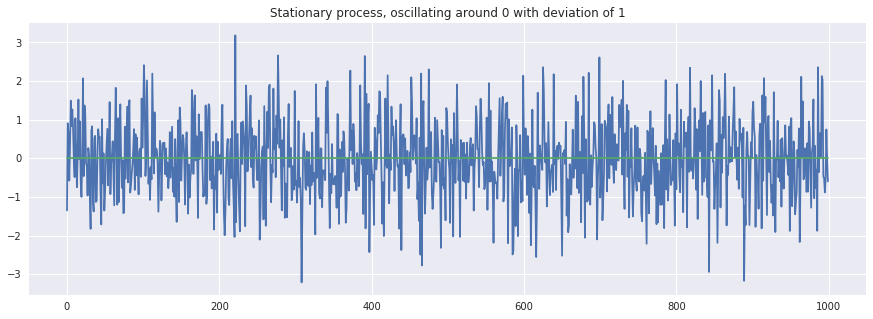

In [3]:
# Random time series
white_noise = np.random.normal(size=1000)
# Plot white noise
with plt.style.context('seaborn'):
    plt.figure(figsize=(15, 5))
    plt.title("Stationary process, oscillating around 0 with deviation of 1")
    plt.plot(white_noise)
    plt.plot(range(len(white_noise)),[0] * len(white_noise))


Now generate a new one with each subsequent value depending on the previous: $x_{t} = \rho x_{t-1} + e_{t}$

In [4]:
def plot_process(samples=1000, rho=0):
    """
    Arguments:
    ------------------------------------
        samples : int
                Number of points to plot
        rho     : float or int
                Dickey-Fuller rho-value           
    """
    # Define random points of count samples and of normal distribution
    x = w = np.random.normal(size=samples)
    # Create dependency on the previous subsequent value
    for t in range(samples):
        x[t] = rho * x[t-1] + w[t]
    # Plot
    with plt.style.context('seaborn'):
        plt.figure(figsize=(15,7), facecolor='#89a1c3')
        plt.plot(x)
        plt.title(f'Rho:{rho}'+'\n'+f'Dickey-Fuller p-value: {round(sm.tsa.stattools.adfuller(x)[1], 3)}')
        
    
        

#### Dickey-Fuller stationarity test:
 If we can get a stationary series from a non-stationary series using the first difference, we call those series integrated of order 1

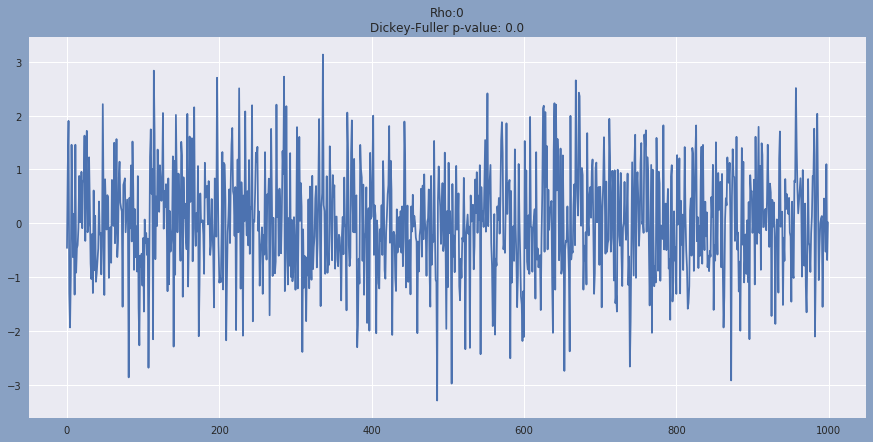

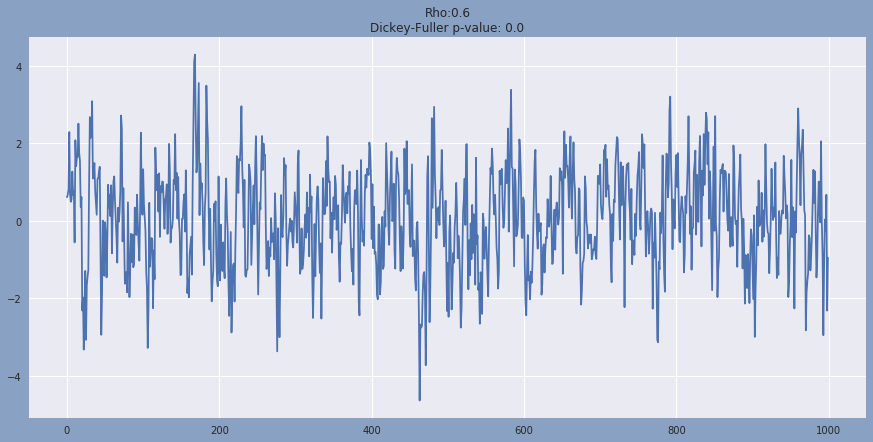

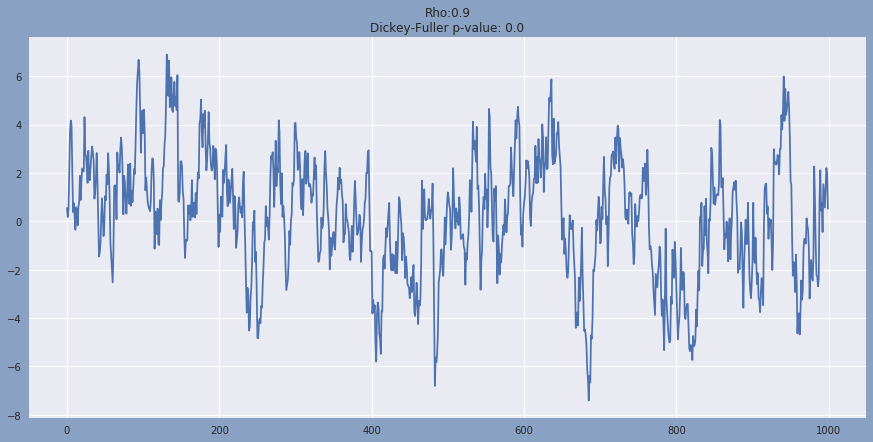

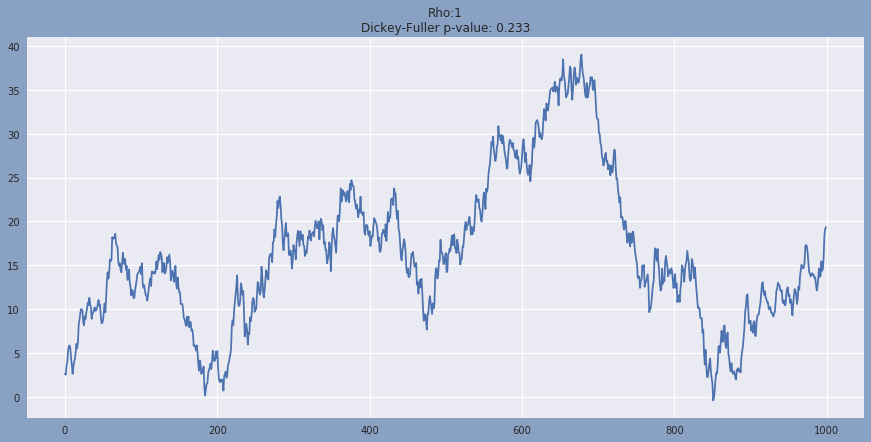

In [5]:
for rho in [0, 0.6, 0.9, 1]:
    plot_process(rho=rho)

Approaches to get rid of non-stationarity:
* various order differences
* trend removal
* seasonality removal
* smoothing 
* transformations (for example logarithmic or exponential)

## Make time-series stationary 

In [6]:
def tsplot(series, lags=None, figsize=(12,10), style='seaborn'):
    # forcely convert series to pandas.Series
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    # Use style pattern
    with plt.style.context(style):
        # Create a figure of figsize
        plt.figure(figsize=figsize, facecolor='#f9c8da')
        layout = (2,2)
        # Create subplots
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        # Plot the first plot
        series.plot(ax=ts_ax)
        # Calculate the p-value
        p_value = sm.tsa.stattools.adfuller(series)[1]
        # Set title
        ts_ax.set_title("Time Series analysis Plots \n Dickey-Fuller: {0:.5f}".format(p_value))
        
        # Plot the second and third plot
        smt.graphics.plot_acf(series,lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(series, lags=lags, ax=pacf_ax)
        
        plt.tight_layout()
    

/home/yurii/Work/environments/ts/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


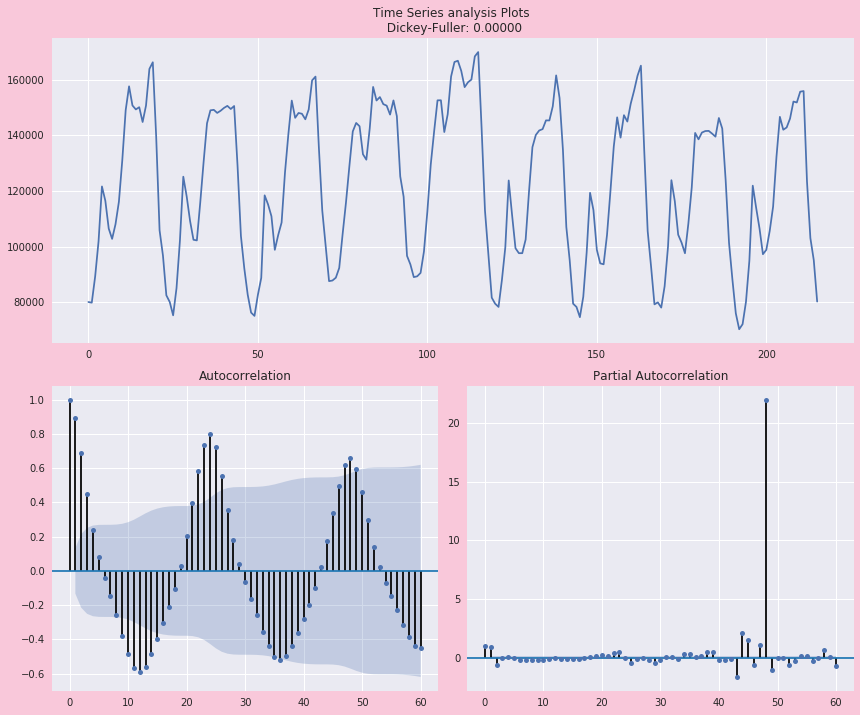

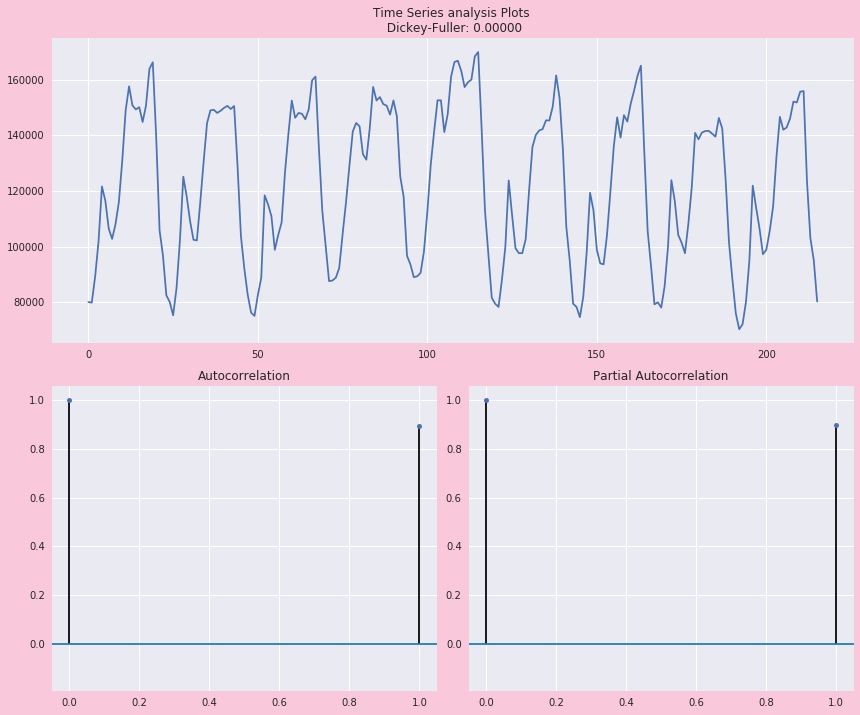

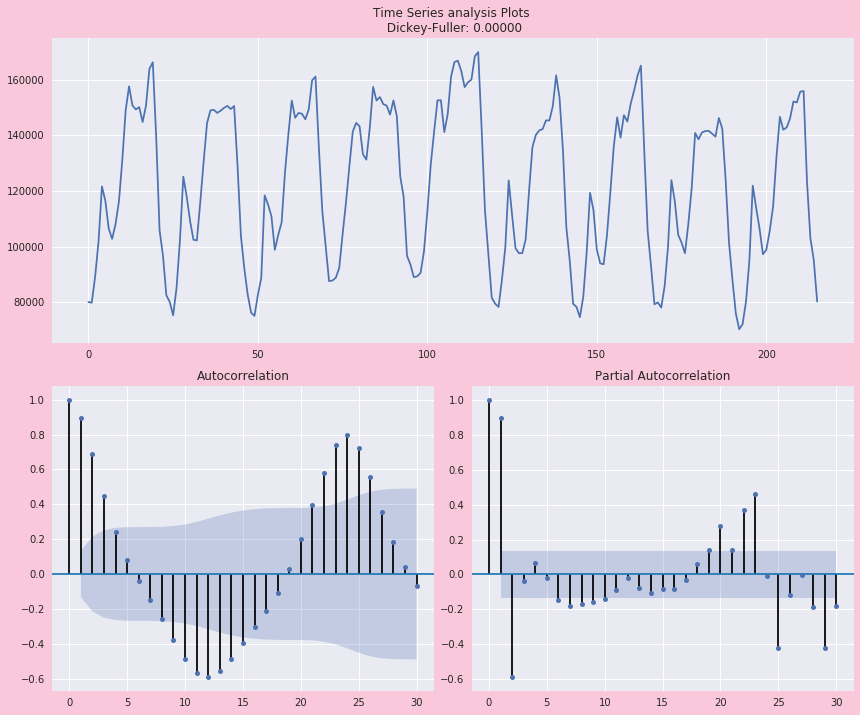

In [7]:
tsplot(ads.Ads, lags=60)
tsplot(ads.Ads, lags=1)
tsplot(ads.Ads, lags=30)


To deal with seasonality, perform the **seasonal difference**:

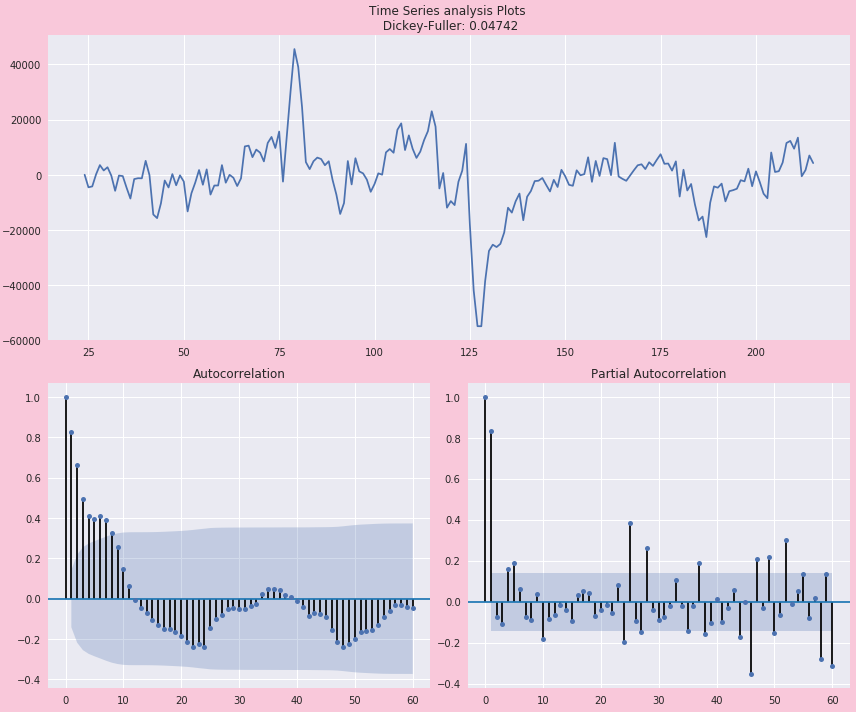

In [8]:
ads_diff = ads.Ads - ads.Ads.shift(24)

tsplot(ads_diff[24:], lags=60)

At the **Autocorrelation** plot we notice, that the autocorrelation function still needs to remove a lag, so let's take the first differences, substracting the series from itself with lag 1

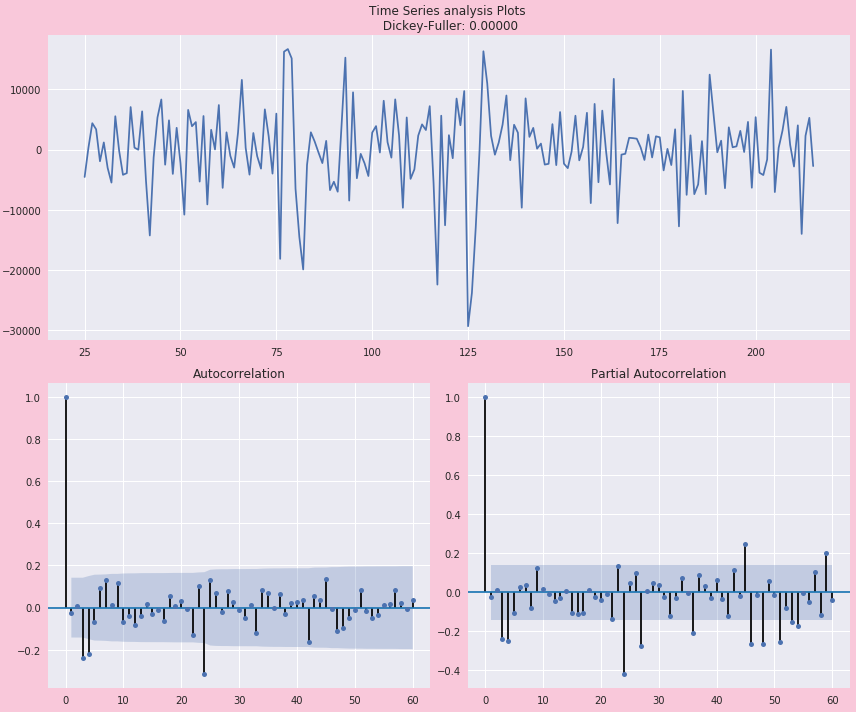

In [9]:
ads_diff = ads_diff - ads_diff.shift(1)

tsplot(ads_diff[25:], lags=60)

Now the time series are oscillating around zero, the Dickey-Fuller test tells the time series now is stationary.

Let's start modelling! Start from SARIMA.

**SARIMA** stands for Seasonal AutoRegressive Integrated Moving Average model.

* S(s) - season period length of the time series. S is for seasonality.

* AR(p) - autoregressive model (regression of the time series onto itself). 
    
    **Basic assumption**: current series values depend on the previous values with some lags, maximum lag is __p_. How can I determine the initial _p_? - Just look at PACF plot and find the biggest significant lag, after which **most** other lags are unsignificant.
 
 
* I(d) - order of integration. It is just the number of nonseasonal differences, which are needed to stationarize the time series.

 
* MA(q) - moving average model. In a nutshell: moving average models the error of time series with the assumption that the *current error depends on the previous with some lags as **q**.* The initial **q** can be found at ACF plot as the most significant lag, after which, most of the lags are unsignificant.


                                            Models:
* ARMA(p, q) - Auto regressive moving average model. Can be applied to the stational series only.
* ARIMA(p,d,q) - AutoRegressiveIntegratedMovingAverage model. Can be applied to non-stationary time series with the help of non-seasonal differences. 
* SARIMA(p,d,q,s)

                               What does the (P,D,Q) parameters mean?
* _P_ - order of autoregression for the seasonal component of the model (can be derived from PACF). _Pay attention_ to the number of significant lags which are multiples of the season period length _(If len(season)==7 and 7th; 14th lags are significant in PACF, then initial **p=2**  )_

* _Q_ - Order of the error for time series, can be derived from ACF. The number of significant lags at the ACF plot tell us, which *q* to choose, the same as for p in PACF.

* _D_ - Order of seasonal integration. 1 if there are seasonal difference applied, 0 if there is no seasonal difference.

## Build SARIMA model

Now let's try to pick the proper initial parameters $p, q, d$ for different models.

* $ p = 4$, because the fourth lag is the last significant lag on the PACF (right bottom plot) ;
* $ q = 4$, as the fourth lag on the ACF plot (left bottom) is the last significant lag;
* $d = 1$, as we've set the first difference;


* Order of autoregression:       $P = 2$, since 24-th and 48-th lag on PACF are significant;
* Order of seasonal integration: $D = 1$, as we've performed seasonal differentiation;
* Order of time series error:    $Q = 1$, because the 24-th lag on ACF in significant, though 48-th is not

In [10]:
# Set initial values and bounds for them. Try also to pick neighbouring values
ps = range(2,5)
qs = range(2,5)
d = 1

Ps = range(0,2)
Qs = range(0,2)
D = 1
# Seasonal length
s = 24

# Create list of all the possible combinations of parameters
parameters_list = list(product(ps, qs, Ps, Qs))
parameters_list

[(2, 2, 0, 0),
 (2, 2, 0, 1),
 (2, 2, 1, 0),
 (2, 2, 1, 1),
 (2, 3, 0, 0),
 (2, 3, 0, 1),
 (2, 3, 1, 0),
 (2, 3, 1, 1),
 (2, 4, 0, 0),
 (2, 4, 0, 1),
 (2, 4, 1, 0),
 (2, 4, 1, 1),
 (3, 2, 0, 0),
 (3, 2, 0, 1),
 (3, 2, 1, 0),
 (3, 2, 1, 1),
 (3, 3, 0, 0),
 (3, 3, 0, 1),
 (3, 3, 1, 0),
 (3, 3, 1, 1),
 (3, 4, 0, 0),
 (3, 4, 0, 1),
 (3, 4, 1, 0),
 (3, 4, 1, 1),
 (4, 2, 0, 0),
 (4, 2, 0, 1),
 (4, 2, 1, 0),
 (4, 2, 1, 1),
 (4, 3, 0, 0),
 (4, 3, 0, 1),
 (4, 3, 1, 0),
 (4, 3, 1, 1),
 (4, 4, 0, 0),
 (4, 4, 0, 1),
 (4, 4, 1, 0),
 (4, 4, 1, 1)]

In [26]:
def optimize_sarima(parameters_list, d, D, s):
    """
    Description: Optimize SARIMA parameters
    
    Arguments:
    -------------------------------------------------------------------
        parameters_list : list, tuple or any other iterable, including 4 iterable elements of equal shape.
                iterable of (p, q, P, Q) parameters, which are ARMA parameters of type int / float.
        d : int
                integrational order of the ARIMA model
        D : int
                seasonal integrational order
        s : int
                length of the season
                
                
    Return: pandas.DataFrame
            Dataframe with parameters and corresponding AIC
    """
    results = []
    best_aic = float("inf")
    failures = []
    for param in tqdm(parameters_list):
        # Use try - except, because model fails to converge on some parameters combinations
        try:
            model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]),
                                      seasonal_order=(param[2], D, param[3], s)).fit(display=-1)
        except:
            failures.append(param)
            continue
        # Apply Akaike Information Criterion to the model
        aic = model.aic
        # Check, if we can optimize model and choose the best option
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
        result_table = pd.DataFrame(results)
        result_table.columns = ['parameters', 'AIC']
        # Sort dataframe by 'AIC' in the ascending order
        result_table = result_table.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    if len(failures) > 0:
        print(f'{len(failures)} Combinations failed: {failures}.')
    
    return result_table    

In [27]:
%%time
result_table = optimize_sarima(parameters_list, d, D, s)

 86%|████████▌ | 31/36 [03:04<00:45,  9.15s/it]/home/yurii/Work/environments/ts/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|██████████| 36/36 [03:26<00:00,  5.74s/it]

8 Combinations failed: [(3, 4, 0, 0), (3, 4, 0, 1), (3, 4, 1, 0), (3, 4, 1, 1), (4, 4, 0, 0), (4, 4, 0, 1), (4, 4, 1, 0), (4, 4, 1, 1)].
CPU times: user 5min 47s, sys: 6min 8s, total: 11min 55s
Wall time: 3min 26s


In [30]:
result_table.head()

,parameters,AIC
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


In [31]:
# Pick up the parameters with the lowest Akaike information criteria
p, q, P, Q = result_table.parameters[0]

# Define model with the best parameters
best_model = sm.tsa.statespace.SARIMAX(ads.Ads, order=(p,d,q), seasonal_order=(P,D,Q,s)).fit(disp=-1)

In [32]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 24)   Log Likelihood               -1936.321
Date:                            Tue, 23 Oct 2018   AIC                           3888.642
Time:                                    15:03:41   BIC                           3914.660
Sample:                                         0   HQIC                          3899.181
                                            - 216                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.5503      0.306   

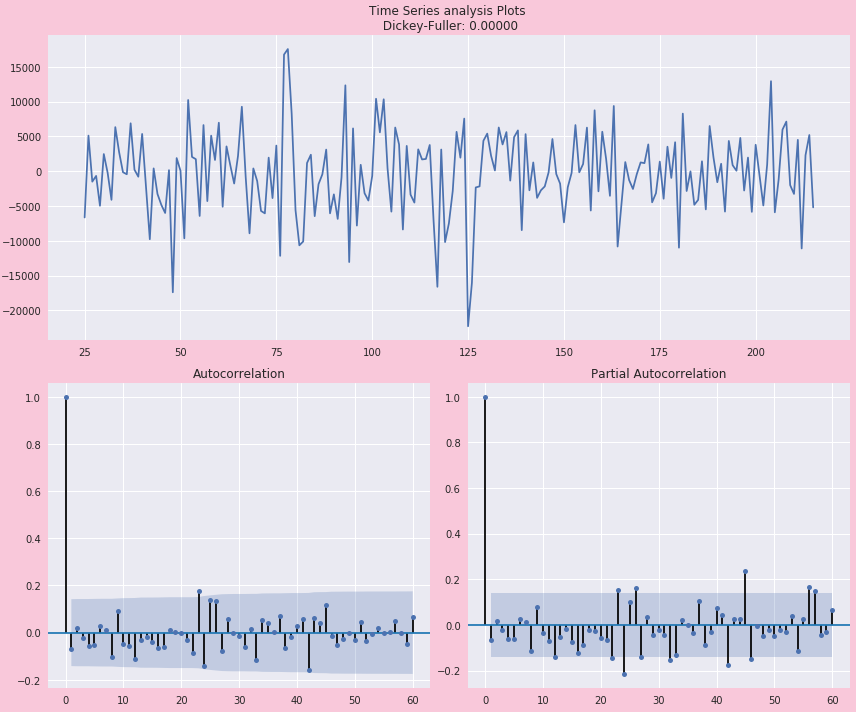

In [36]:
tsplot(best_model.resid[24+1:], lags=60)

It is clear from the plot, that the residuals are stationary, there are no apparent autocorelations. 

So, it's high time to predict something

In [ ]:
def plot_sarima(series, model, num_steps):
    """
        Descriptio
    """